In [47]:
import ast

from task_decomposition.utils.plotting import visualize_trajectory_decompositions
from task_decomposition.data.groundtruths import GROUND_TRUTH
from task_decomposition.data.gpt_outputs import GPT_OUTPUTS

from transformers import BertTokenizer, BertModel
from scipy.spatial.distance import cosine

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


def calculate_iou(A, B, option):
    """
    Calculate the Intersection over Union (IoU) between two trajectory decompositions.

    Args:
    A (list of dictionaries): The first trajectory decomposition.
    B (list of dictionaries): The second trajectory decomposition.

    Returns:
    float: The IoU value between the two decompositions.
    """
    if option == "steps":
        set_a = set((e["start_step"], e["end_step"]) for e in A)
        set_b = set((e["start_step"], e["end_step"]) for e in B)
    else:
        raise NotImplementedError

    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    iou = intersection / union if union != 0 else 0.0
    return iou


def get_GPT_subtask_decomposition_from_response(response: str) -> list:
    """ """
    # Isolating the subtask_decomposition list part
    start = response.find('subtask_decomposition = [') + len('subtask_decomposition = [')
    end = response.find(']', start)
    list_str = response[start:end]

    # Converting string representation of list to actual Python list
    subtask_decomposition = ast.literal_eval('[' + list_str + ']')
    return subtask_decomposition

def bert_encode(text):
    inputs = tokenizer(text, return_tensors='pt')
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)[0].detach().numpy()

def compare_similarity(A, B):
    embedding1 = bert_encode(A)
    embedding2 = bert_encode(B)
    similarity = 1 - cosine(embedding1, embedding2)
    return similarity

def adjust_predicted_to_actual(actual, predicted):
    predicted_adjusted = []

    # Function to calculate overlap between two intervals
    def overlap(a, b):
        return max(0, min(a['end_step'], b['end_step']) - max(a['start_step'], b['start_step']))

    # Function to merge subtasks
    def merge_subtasks(subtasks):
        if not subtasks:
            return None
        # Merge all subtask descriptions with a comma and adjust the start and end steps
        merged = {
            "start_step": min(subtask["start_step"] for subtask in subtasks),
            "end_step": max(subtask["end_step"] for subtask in subtasks),
            "subtask": ", ".join(subtask["subtask"] for subtask in subtasks),
        }
        return merged

    # Iterate over actual subtasks to find the best matching predicted subtasks
    for actual_subtask in actual:
        # Find all predicted subtasks that overlap with the current actual subtask
        overlapping_subtasks = [pred_sub for pred_sub in predicted if overlap(actual_subtask, pred_sub) > 0]

        # Merge overlapping subtasks and add to the adjusted list
        merged_subtask = merge_subtasks(overlapping_subtasks)
        if merged_subtask:
            predicted_adjusted.append(merged_subtask)

    return predicted_adjusted

# def merge_predicted(actual, predicted):
#     i = 0
#     predicted_adjusted = []
#     for a in actual:
#         for p in predicted[i:]:
#             if a['start_step'] <= p['start_step'] and a['end_step'] >= p['end_step']:
#                 p['subtask'] = a['subtask']
#                 predicted_adjusted.append({'start_'})

#     return predicted_adjusted

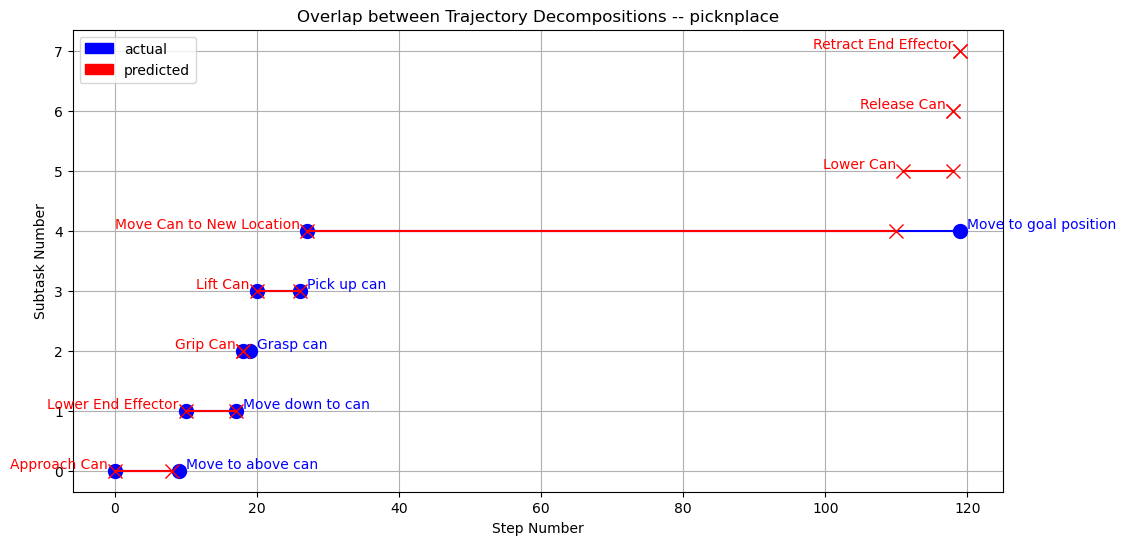

'Move to above can' compared with 'Approach Can': 
  0.6636903285980225
'Move down to can' compared with 'Lower End Effector': 
  0.4783613979816437
'Grasp can' compared with 'Grip Can': 
  0.8880956172943115
'Pick up can' compared with 'Lift Can': 
  0.7308422327041626
'Move to goal position' compared with 'Move Can to New Location': 
  0.5380635261535645
'Move to goal position' compared with 'Lower Can. Release Can. Retract End Effector': 
  0.4531707763671875


In [42]:
env = "picknplace"
actual = GROUND_TRUTH[env]
predicted = GPT_OUTPUTS[env]
# predicted_adjusted = adjust_predicted_to_actual(actual, predicted)
visualize_trajectory_decompositions(
    actual=actual,
    predicted=predicted,
    title=f"Overlap between Trajectory Decompositions -- {env}",
)

# Example of comparing two subtasks
for idx, (A, B) in enumerate(zip(actual, predicted)):
    A_subtask = A["subtask"]
    B_subtask = B["subtask"]
    similiarity = compare_similarity(A_subtask, B_subtask)
    print(f"'{A_subtask}' compared with '{B_subtask}': ")
    print(f"  {similiarity}")

actual_last = actual[-1]['subtask']
predicted_last = '. '.join([p['subtask'] for p in predicted[-3:]])
similiarity = compare_similarity(actual_last, predicted_last)

print(f"'{actual_last}' compared with '{predicted_last}': ")
print(f"  {similiarity}")

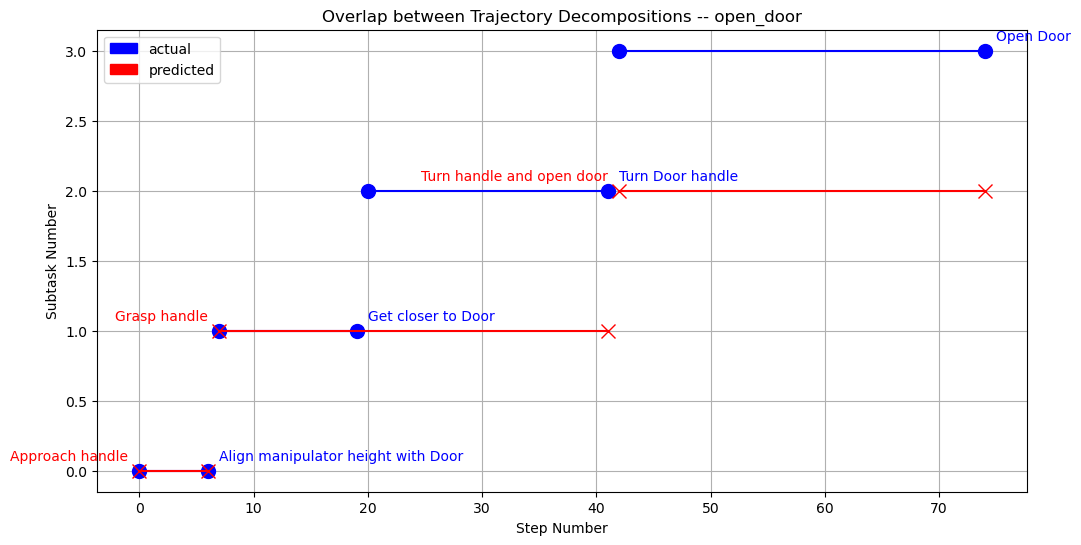

'Align manipulator height with Door' compared with 'Approach handle': 
  0.5631235837936401
'Get closer to Door' compared with 'Grasp handle': 
  0.6329072713851929
'Turn Door handle' compared with 'Turn handle and open door': 
  0.9023875594139099
Full trajectory decomposition: 0.813240647315979


In [17]:
env = "open_door"
actual = GROUND_TRUTH[env]
predicted = GPT_OUTPUTS[env]
visualize_trajectory_decompositions(
    actual=actual,
    predicted=predicted,
    title=f"Overlap between Trajectory Decompositions -- {env}",
)

# Example of comparing two subtasks
for A, B in zip(actual, predicted):
    A_subtask = A["subtask"]
    B_subtask = B["subtask"]
    print(f"'{A_subtask}' compared with '{B_subtask}': ")
    print(f"  {compare_similarity(A_subtask, B_subtask)}")

actual_full_decompsoition = ''.join([s['subtask'] for s in actual])
predicted_full_decompsoition = ''.join([s['subtask'] for s in predicted])
print(f"Full trajectory decomposition: {compare_similarity(actual_full_decompsoition, predicted_full_decompsoition)}")

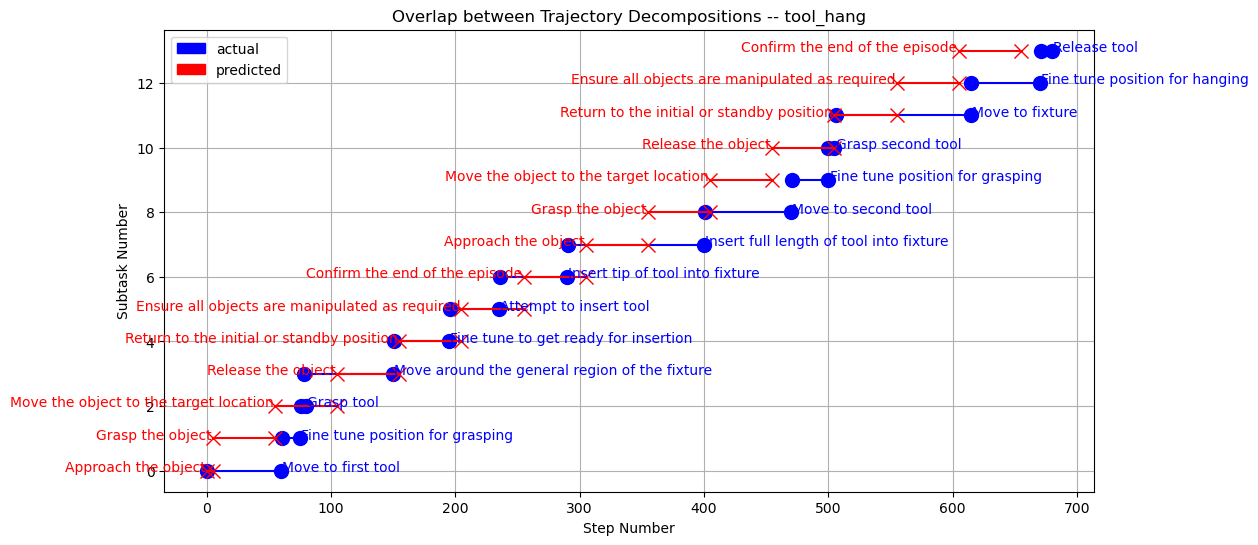

'Move to first tool' compared with 'Approach the object': 
  0.686194658279419
'Fine tune position for grasping' compared with 'Grasp the object': 
  0.6728275418281555
'Grasp tool' compared with 'Move the object to the target location': 
  0.5958406329154968
'Move around the general region of the fixture' compared with 'Release the object': 
  0.6355777382850647
'Fine tune to get ready for insertion' compared with 'Return to the initial or standby position': 
  0.6163419485092163
'Attempt to insert tool' compared with 'Ensure all objects are manipulated as required': 
  0.5390421152114868
'Insert tip of tool into fixture' compared with 'Confirm the end of the episode': 
  0.4867117404937744
'Insert full length of tool into fixture' compared with 'Approach the object': 
  0.4990508556365967
'Move to second tool' compared with 'Grasp the object': 
  0.6548840403556824
'Fine tune position for grasping' compared with 'Move the object to the target location': 
  0.684144914150238
'Grasp se

In [48]:
env = "tool_hang"
actual = GROUND_TRUTH[env]
predicted = GPT_OUTPUTS[env]
visualize_trajectory_decompositions(
    actual=actual,
    predicted=predicted,
    title=f"Overlap between Trajectory Decompositions -- {env}",
)

# Example of comparing two subtasks
for A, B in zip(actual, predicted):
    A_subtask = A["subtask"]
    B_subtask = B["subtask"]
    print(f"'{A_subtask}' compared with '{B_subtask}': ")
    print(f"  {compare_similarity(A_subtask, B_subtask)}")

actual_full_decompsoition = ''.join([s['subtask'] for s in actual])
predicted_full_decompsoition = ''.join([s['subtask'] for s in predicted])
print(f"Full trajectory decomposition: {compare_similarity(actual_full_decompsoition, predicted_full_decompsoition)}")

In [11]:
env = "transport"
actual = GROUND_TRUTH[env]
predicted = GPT_OUTPUTS[env]
visualize_trajectory_decompositions(
    actual=actual,
    predicted=predicted,
    title=f"Overlap between Trajectory Decompositions -- {env}",
)

# Example of comparing two subtasks
for A, B in zip(actual, predicted):
    A_subtask = A["subtask"]
    B_subtask = B["subtask"]
    print(f"'{A_subtask}' compared with '{B_subtask}': ")
    print(f"  {compare_similarity(A_subtask, B_subtask)}")

actual_full_decompsoition = ''.join([s['subtask'] for s in actual])
predicted_full_decompsoition = ''.join([s['subtask'] for s in predicted])
print(f"Full trajectory decomposition: {compare_similarity(actual_full_decompsoition, predicted_full_decompsoition)}")

KeyError: 'transport'